<a href="https://colab.research.google.com/github/AryanPROFFESOR/AryanPROFFESOR/blob/main/membrane_potential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === Cell 0: Install & Imports ===
!pip install numpy scipy pandas matplotlib networkx

import numpy as np
import pandas as pd
import scipy
from scipy.integrate import odeint
from scipy.linalg import eig
import networkx as nx
import matplotlib.pyplot as plt


In [2]:
# === Cell 1: Global constants ===

R = 8.314      # J/(mol*K)
F = 96485     # C/mol
T_C = 37.0
T_K = T_C + 273.15

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


In [3]:
# === Cell 2: Variant physics abstraction ===

class Variant:
    def __init__(self, gene, effect):
        """
        effect ∈ {'lof','gof','neutral'}
        """
        self.gene = gene
        self.effect = effect

    def kinetic_multiplier(self):
        if self.effect == 'lof':
            return {'k_OI': 1.5, 'k_IO': 0.7}
        if self.effect == 'gof':
            return {'k_OI': 0.6, 'k_IO': 1.3}
        return {'k_OI': 1.0, 'k_IO': 1.0}


In [4]:
# === Cell 3: Markov channel model ===

class MarkovNaChannel:
    def rate(self, k0, Ea, z, V):
        return k0 * np.exp(-Ea / (R*T_K)) * np.exp(z*F*V/(R*T_K))

    def rates(self, V, variant: Variant):
        base = {
            'k_CO': self.rate(0.5, 35000, 0.8, V),
            'k_OC': self.rate(0.2, 40000, -0.3, V),
            'k_OI': self.rate(0.1, 38000, 0.5, V),
            'k_IO': self.rate(0.05,42000,-0.2, V)
        }
        mult = variant.kinetic_multiplier()
        base['k_OI'] *= mult['k_OI']
        base['k_IO'] *= mult['k_IO']
        return base

    def steady_open_prob(self, V, variant):
        k = self.rates(V, variant)
        Q = np.array([
            [-k['k_CO'], k['k_CO'], 0],
            [k['k_OC'], -(k['k_OC']+k['k_OI']), k['k_OI']],
            [0, k['k_IO'], -k['k_IO']]
        ])
        A = np.vstack([Q.T, np.ones(3)])
        b = np.array([0,0,0,1])
        p = np.linalg.lstsq(A, b, rcond=None)[0]
        return p[1]


In [5]:
# === Cell 4: HH parameter extraction ===

def extract_hh_params(channel, variant):
    V = np.linspace(-80, 40, 200)
    p_open = np.array([channel.steady_open_prob(v*1e-3, variant) for v in V])
    V_half = V[np.argmin(np.abs(p_open - 0.5))]
    gbar = 120 * np.max(p_open)

    return {
        'V_half': V_half,
        'gbar': gbar
    }


In [6]:
# === Cell 5: Hodgkin–Huxley neuron ===

class HHNeuron:
    def __init__(self, params):
        self.gNa = params['gbar']
        self.gK  = 36
        self.gL  = 0.3
        self.ENa = 50
        self.EK  = -77
        self.EL  = -54.4
        self.C  = 1.0

    def alpha_m(self, V): return 0.1*(V+40)/(1-np.exp(-(V+40)/10))
    def beta_m(self, V):  return 4*np.exp(-(V+65)/18)
    def alpha_h(self, V): return 0.07*np.exp(-(V+65)/20)
    def beta_h(self, V):  return 1/(1+np.exp(-(V+35)/10))
    def alpha_n(self, V): return 0.01*(V+55)/(1-np.exp(-(V+55)/10))
    def beta_n(self, V):  return 0.125*np.exp(-(V+65)/80)

    def deriv(self, y, t, I):
        V,m,h,n = y
        INa = self.gNa*m**3*h*(V-self.ENa)
        IK  = self.gK*n**4*(V-self.EK)
        IL  = self.gL*(V-self.EL)

        dV = (I-INa-IK-IL)/self.C
        dm = self.alpha_m(V)*(1-m)-self.beta_m(V)*m
        dh = self.alpha_h(V)*(1-h)-self.beta_h(V)*h
        dn = self.alpha_n(V)*(1-n)-self.beta_n(V)*n
        return [dV,dm,dh,dn]


In [7]:
# === Cell 6: Morris–Lecar stability ===

def morris_lecar_fixed(I):
    def f(x):
        V,w = x
        m = 0.5*(1+np.tanh((V+1)/15))
        dV = I - m*(V-100) - w*(V+70) - 0.5*(V+50)
        dw = 0.1*(0.5*(1+np.tanh((V-10)/14))-w)
        return [dV,dw]
    return scipy.optimize.fsolve(f,[ -60,0.2 ])


In [8]:
# === Cell 7: Hindmarsh–Rose ===

def HR(state,t,I):
    x,y,z = state
    dx = y - x**3 + 3*x**2 + I - z
    dy = 1 - 5*x**2 - y
    dz = 0.01*(4*(x+1.6)-z)
    return [dx,dy,dz]


In [9]:
# === Cell 8: Kuramoto synchrony ===

def kuramoto(phases,t,K,omega):
    N=len(phases)
    dtheta=[]
    for i in range(N):
        coupling = np.sum(np.sin(phases-phases[i]))
        dtheta.append(omega[i]+K/N*coupling)
    return dtheta


In [10]:
# === Cell 9: Network stability ===

def network_lambda_max(adj):
    eigvals = np.linalg.eigvals(adj)
    return np.max(np.real(eigvals))


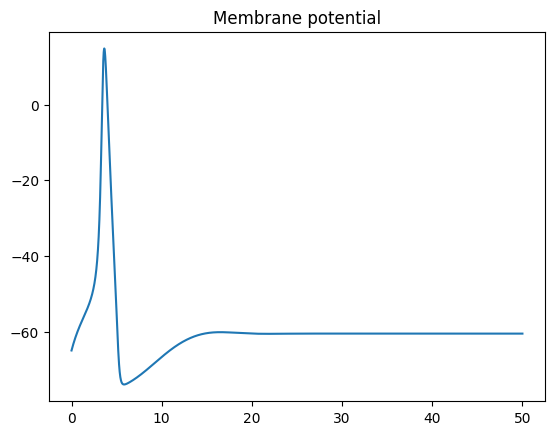

λ_max = 6.208587453647974


In [11]:
# === Cell 10: End-to-end execution ===

variant = Variant("SCN1A","gof")
channel = MarkovNaChannel()

hh_params = extract_hh_params(channel, variant)
neuron = HHNeuron(hh_params)

t = np.linspace(0,50,5000)
y0 = [-65,0.05,0.6,0.32]
sol = odeint(neuron.deriv,y0,t,args=(10,))

plt.plot(t,sol[:,0])
plt.title("Membrane potential")
plt.show()

# Network
A = nx.watts_strogatz_graph(50,6,0.3)
Adj = nx.to_numpy_array(A)
print("λ_max =", network_lambda_max(Adj))
